# Notebook: Sale and Traffic Predictions

In [1]:
from __future__ import division
#from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [26]:
df1=pd.read_csv("training_Sales.csv")
df2=pd.read_csv("training_Traffic.csv")

In [3]:
df1.head().transpose()

,0,1,2,3,4
Date,2013-11-07 13:00:00,2013-11-07 13:15:00,2013-11-07 13:30:00,2013-11-07 13:45:00,2013-11-07 14:00:00
Value,830,885,938,804,793


In [6]:
df2.head().transpose()

,0,1,2,3,4
Date,2015-01-01 10:00:00,2015-01-01 10:15:00,2015-01-01 10:30:00,2015-01-01 10:45:00,2015-01-01 11:00:00
Value,0,1,4,3,1


In [5]:
df1.tail().transpose()

,67053,67054,67055,67056,67057
Date,2018-05-06 18:00:00,2018-05-06 18:15:00,2018-05-06 18:30:00,2018-05-06 18:45:00,2018-05-06 19:00:00
Value,772,872,753,793,759


In [7]:
df2.tail().transpose()

,58432,58433,58434,58435,58436
Date,2018-05-06 18:15:00,2018-05-06 18:30:00,2018-05-06 18:45:00,2018-05-06 19:00:00,2018-05-06 21:00:00
Value,6,4,1,4,1


# Data Types

In [9]:
df1.dtypes

Date     object
Value     int64
dtype: object

In [31]:
df1['Date'] =  pd.to_datetime(df1['Date'], format='%Y%m%d %H:%M:%S.%f')

In [17]:
df1.dtypes

Date     datetime64[ns]
Value             int64
dtype: object

In [10]:
df2.dtypes

Date     object
Value     int64
dtype: object

In [32]:
df2['Date'] =  pd.to_datetime(df2['Date'], format='%Y%m%d %H:%M:%S.%f')

# Anomaly Detection using a Low-Pass Filter

Convolution is a mathematical operation that is performed on two functions to produce a third function. Mathematically, it could be described as the integral of the product of two functions, after one is reversed and shifted: $f*g(t)$ = $\int_{-\infty}^{\infty} f(T)*g(t-T) dT$, where f(T) an input function containing the quantity of interest (e.g. sunspot count at time T). g(t —T) is the weighting function shifted by an amount t. This way as t changes, different weights are assigned to the input function f(T). In our case, f(T) represents the sunspot counts at time T.  g(t —T) is the moving average kernel.  

First we need to sort the dataset according to "Date" column.

In [33]:
df1 = df1.sort_values('Date')
df2 = df1.sort_values('Date')

In [12]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

This function helps in exploring the anamolies using stationary standard deviation:

In [13]:
def explain_anomalies(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

This function helps in exploring the anamolies using rolling standard deviation:

In [14]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

The below function helps in generating the plot and flagging the anamolies.
The function supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch between the two:

In [15]:
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    plt.grid(True)
    plt.show()

# Anomaly for Sales

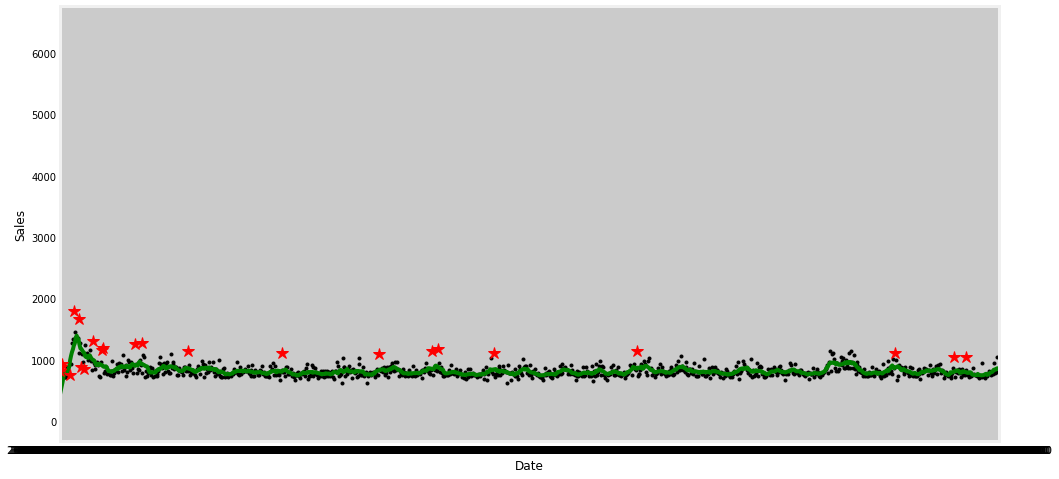

Information about the anomalies model:{'anomalies_dict': OrderedDict([(0, 830L), (15, 1799L), (20, 1114L), (21, 1662L), (23, 880L), (34, 839L), (35, 1304L), (80, 1258L), (87, 788L), (88, 1274L), (137, 1156L), (236, 1111L), (340, 1100L), (396, 1145L), (403, 1186L), (462, 1119L), (614, 1152L), (821, 815L), (891, 679L), (1033, 1226L), (1040, 1122L), (1125, 1299L), (1179, 1171L), (1221, 1183L), (1273, 1146L), (1309, 1076L), (1448, 1160L), (1509, 790L), (1520, 1293L), (1605, 1165L), (1688, 1093L), (1741, 1143L), (1851, 1233L), (1899, 1329L), (1902, 1310L), (1913, 1234L), (1927, 1145L), (1957, 1428L), (1972, 1153L), (2001, 1211L), (2031, 1452L), (2032, 913L), (2090, 1228L), (2091, 788L), (2126, 1085L), (2145, 1179L), (2189, 1223L), (2190, 659L), (2219, 1089L), (2246, 580L), (2248, 1090L), (2348, 1036L), (2669, 1014L), (2699, 1010L), (4572, 1241L), (4640, 576L), (4642, 1060L), (4876, 1025L), (5131, 1068L), (5479, 1297L), (5744, 1237L), (7010, 1063L), (7293, 1160L), (9737, 1035L), (10191, 1165

In [17]:
x= df1['Date']
Y = df1['Value']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Date", sigma_value=3,
             text_ylabel="Sales")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

It is able to detect data points that are 2 sigma away from the fitted curve.

# Anomaly for Traffics

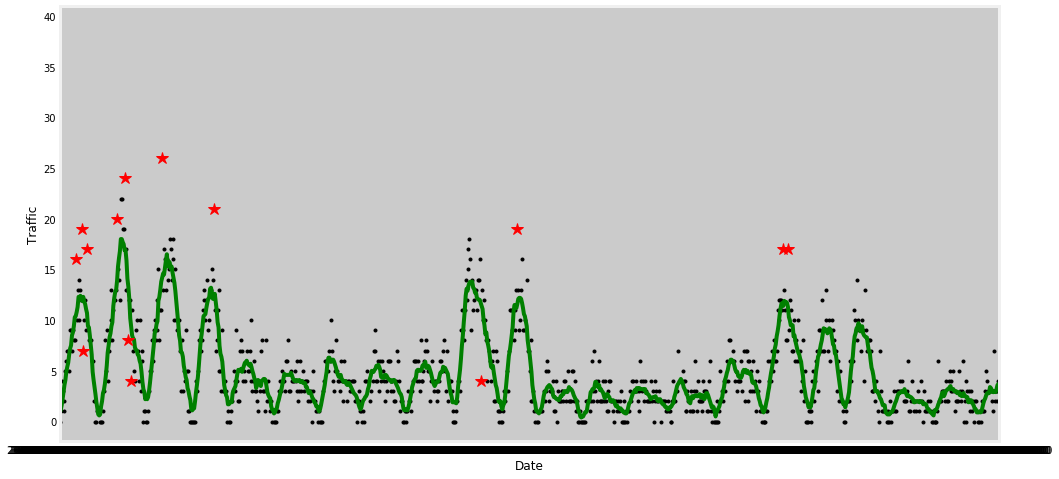

Information about the anomalies model:{'anomalies_dict': OrderedDict([(17, 16L), (24, 19L), (25, 7L), (29, 17L), (61, 20L), (64, 12L), (69, 24L), (76, 4L), (109, 26L), (164, 21L), (448, 4L), (487, 19L), (775, 17L), (856, 4L), (1054, 8L), (1108, 4L), (1115, 12L), (1156, 14L), (1202, 10L), (1207, 11L), (1449, 11L), (1763, 17L), (1769, 19L), (1771, 7L), (1797, 7L), (2140, 13L), (2157, 14L), (2193, 14L), (2437, 3L), (2779, 16L), (2824, 12L), (3143, 3L), (3147, 5L), (3148, 18L), (3368, 11L), (3415, 4L), (3463, 14L), (3472, 14L), (4088, 14L), (4126, 15L), (4161, 10L), (4423, 11L), (4451, 3L), (4454, 13L), (4737, 14L), (5031, 10L), (5325, 11L), (5346, 17L), (5365, 11L), (5582, 9L), (5686, 11L), (5971, 3L), (6002, 18L), (6342, 13L), (6370, 16L), (6480, 9L), (6660, 18L), (6661, 7L), (6664, 20L), (6705, 6L), (6738, 16L), (6986, 13L), (6988, 5L), (7087, 8L), (7284, 9L), (7314, 16L), (7322, 1L), (7360, 3L), (7641, 14L), (7970, 4L), (7978, 5L), (7980, 16L), (8013, 11L), (8015, 1L), (8025, 13L), (89

In [16]:
x= df2['Date']
Y = df2['Value']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Date", sigma_value=3,
             text_ylabel="Traffic")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

# Some Basics statistics

Statistical characteristics for Sales dataset:

In [22]:
df1.describe()

,Value
count,67058.000000
mean,815.701631
std,100.306658
min,0.000000
25%,754.000000
50%,793.000000
75%,851.000000
max,6435.000000


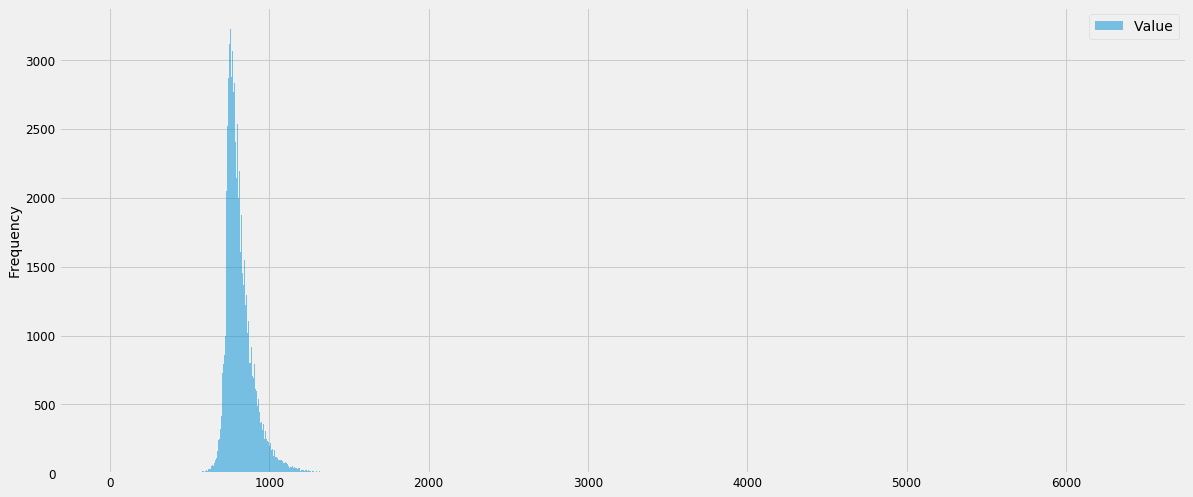

In [65]:
df1[['Value']].plot.hist(alpha=0.5,bins=1000)

Statistical characteristics of Traffics dateset:

In [23]:
df2.describe()

,Value
count,58437.000000
mean,4.208755
std,4.059862
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,39.000000


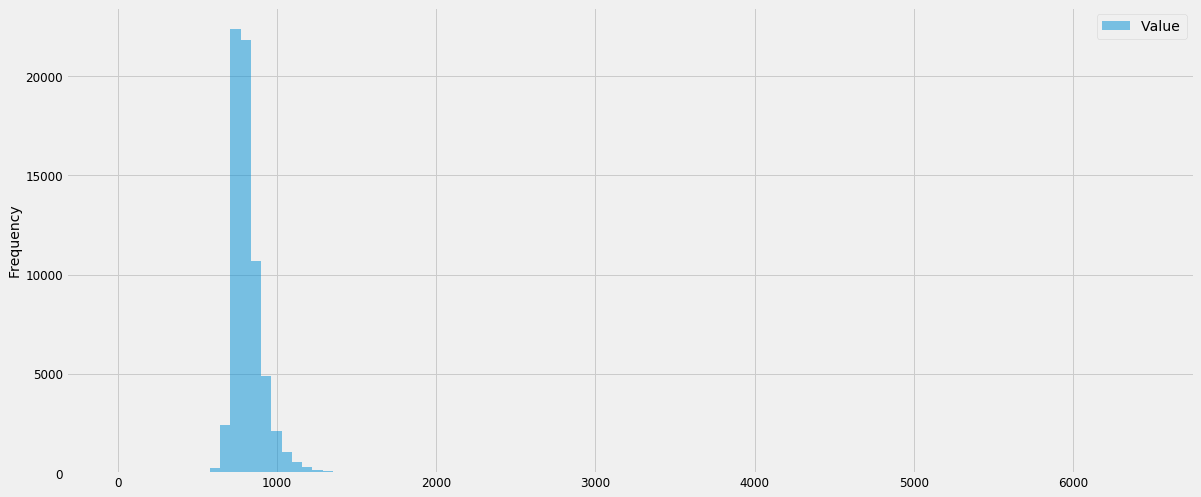

In [69]:
df2[['Value']].plot.hist(alpha=0.5,bins=100)

# Time Series to predict future trends

In [4]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Future trend for Sales

In [20]:
df1['Date'].min(), df1['Date'].max()

(Timestamp('2013-11-07 13:00:00'), Timestamp('2018-05-06 19:00:00'))

We have 5 years of data that should be enough to predict future trends.

# Data Processing 

In [21]:
df1 = df1.sort_values('Date')
df1.isnull().sum()

Date     0
Value    0
dtype: int64

There is no missing values!

# Indexing with Time Series Data

In [11]:
df1 = df1.groupby('Date')['Value'].sum().reset_index()

In [12]:
df1 = df1.set_index('Date')
df1.index

DatetimeIndex(['2013-11-07 13:00:00', '2013-11-07 13:15:00',
               '2013-11-07 13:30:00', '2013-11-07 13:45:00',
               '2013-11-07 14:00:00', '2013-11-07 14:30:00',
               '2013-11-07 14:45:00', '2013-11-07 16:00:00',
               '2013-11-07 18:00:00', '2013-11-07 18:15:00',
               ...
               '2018-05-06 16:45:00', '2018-05-06 17:00:00',
               '2018-05-06 17:15:00', '2018-05-06 17:30:00',
               '2018-05-06 17:45:00', '2018-05-06 18:00:00',
               '2018-05-06 18:15:00', '2018-05-06 18:30:00',
               '2018-05-06 18:45:00', '2018-05-06 19:00:00'],
              dtype='datetime64[ns]', name='Date', length=67058, freq=None)

The current datetime data can be tricky to work with, therefore, I will use the averages daily sales value for that month instead, and I will be using the start of each month as the timestamp.

In [25]:
y = df1['Value'].resample('MS').mean()

In [26]:
y['2017':]

Date
2017-01-01    804.545734
2017-02-01    810.661077
2017-03-01    802.906793
2017-04-01    807.911664
2017-05-01    805.116460
2017-06-01    803.035541
2017-07-01    805.280757
2017-08-01    809.780280
2017-09-01    806.486134
2017-10-01    802.099018
2017-11-01    833.783073
2017-12-01    936.742741
2018-01-01    812.667662
2018-02-01    813.649785
2018-03-01    822.874224
2018-04-01    804.843983
2018-05-01    810.000000
Freq: MS, Name: Value, dtype: float64

# Visualizing Sales Time Series Data

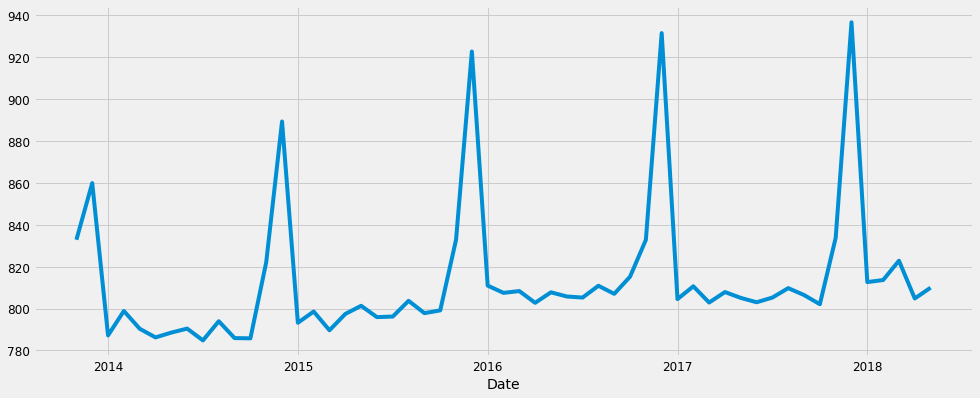

In [27]:
y.plot(figsize=(15, 6))
plt.show()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

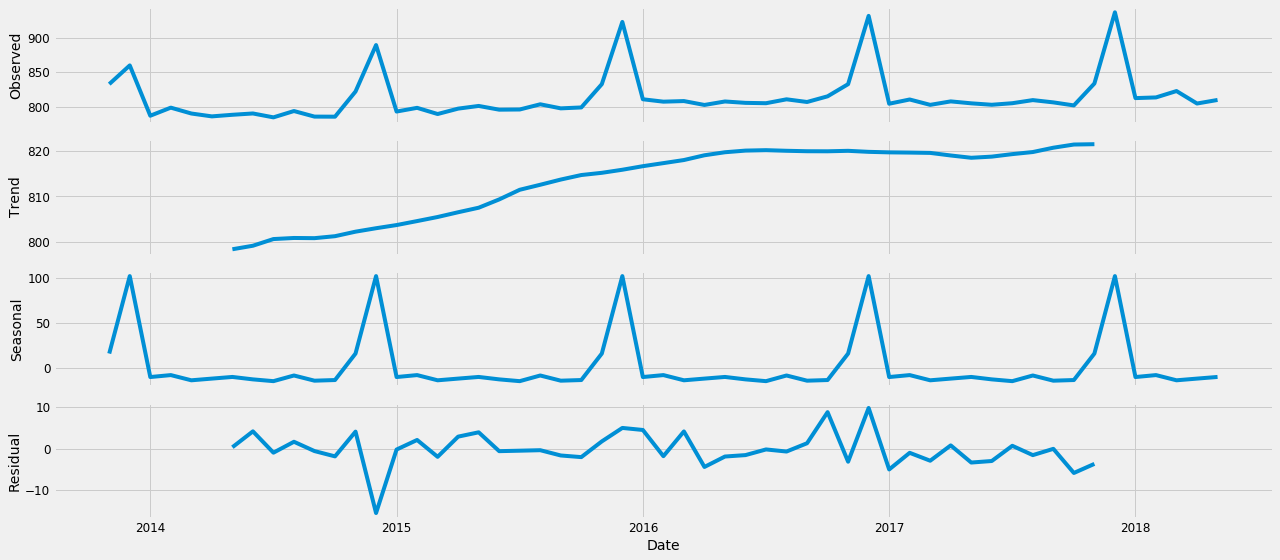

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is stable, along with its obvious seasonality.

# Time series forecasting with Autoregressive Integrated Moving Average (ARIMA)

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [29]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter selection for our sales ARIMA Time Series Model. My goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model:

In [36]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:879.0869787729046
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:650.0179059026013
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:324.35348693408463


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1281.7036141997069
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:316.60277205907573
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:308.5226257601496
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:234.97195826498776


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1124.6611369718796
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:799.0469051099992
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:586.9095027603847
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:303.932102258691


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1248.0581249367492


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:317.851666930296


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:296.9317304449625
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:233.84525822575458


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1252.8028601211872
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:550.4542959612007
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:402.2543693260973
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:308.46450472597417


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1247.4676735254575
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:325.2028716659762
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:306.7940621723225
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:230.5170701050539

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1214.7555035476855
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:518.7246328980453
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:374.92939899424357
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:279.90545579888817


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:988.0678347678464
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:306.7926360640783
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:280.946036854282
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:217.15150322235382


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:749.0116329554836
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:562.1290400133053
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:416.687362507517
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:316.6976634246466


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1300.4060651580348
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:307.29707393549415
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:309.29707167830134
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:222.51647003355177


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1305.2417831116488
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:532.302994812062
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:405.9592339948463
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:287.0101104862445


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1438.9185045086035
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:308.7867762327116
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:290.06394814163855
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:217.24580127378283


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1443.6650605177563
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:544.6503122866159
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:395.65710225008934
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:292.82971253769443


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:685.9193756284352
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:289.92159356661585
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:287.88727825845575
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:205.18573745073218


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:874.3783937986994
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:518.7971296514519
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:373.4452122192935
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:281.67713832219476


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1042.1177227184537
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:289.5504204780085
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:280.5711539988274
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:203.6094897220743
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1245.1584764502845


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

# Fitting the ARIMA model

In [37]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2407      0.218     -1.106      0.269      -0.667       0.186
ma.L1         -0.5279      0.253     -2.083      0.037      -1.025      -0.031
ar.S.L12      -0.2737      0.218     -1.253      0.210      -0.702       0.154
sigma2        49.4851     14.166      3.493      0.000      21.721      77.250


Model diagnostics to investigate any unusual behavior:

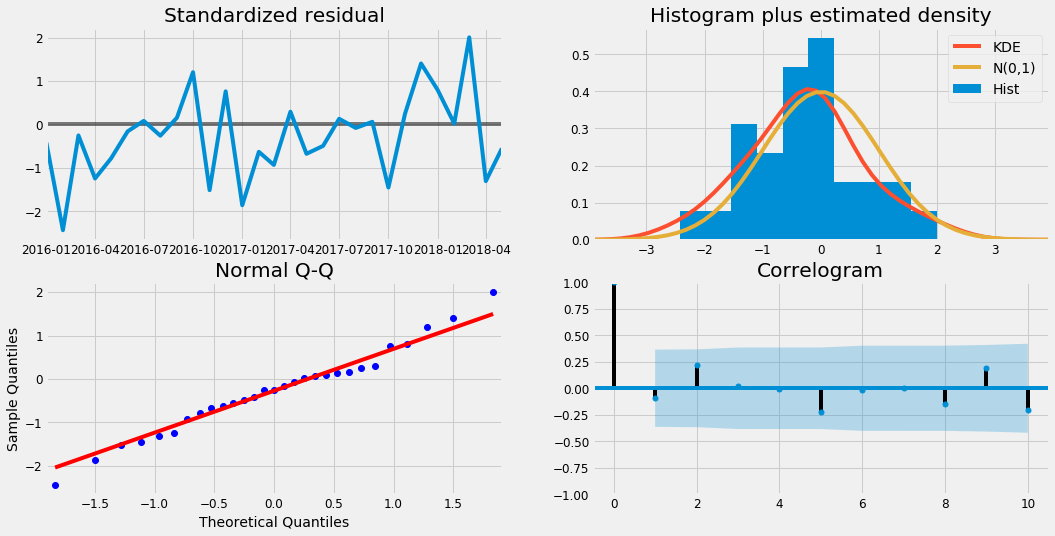

In [38]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

our model diagnostics suggest that the model residuals are near normally distributed.

# Validating forecasts

To investigate the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data

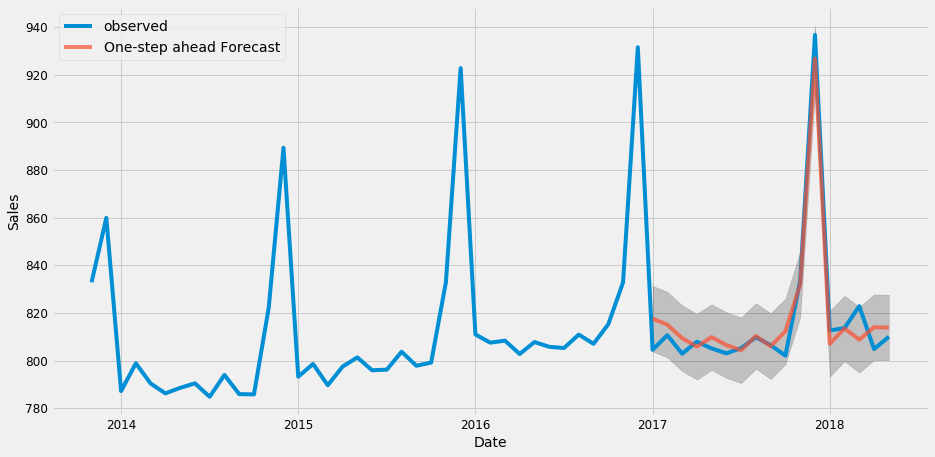

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend and captured the seasonality toward the end of the year.

In [40]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 47.45


In [41]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6.89


# Producing and visualizing forecasts

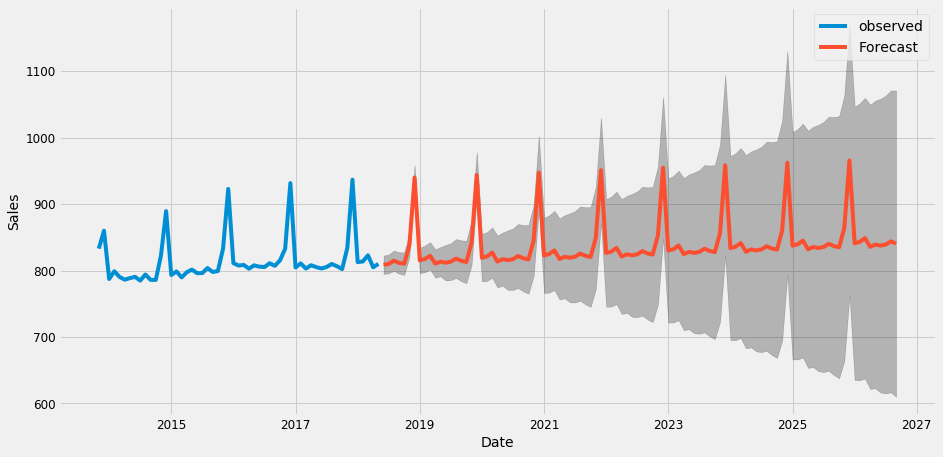

In [42]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# Future trend for Traffics

In [43]:
df2['Date'].min(), df2['Date'].max()

(Timestamp('2015-01-01 10:00:00'), Timestamp('2018-05-06 21:00:00'))

# Data Processing

In [44]:
df2 = df2.sort_values('Date')
df2.isnull().sum()

Date     0
Value    0
dtype: int64

# Time Series Indexing

In [14]:
df2 = df2.groupby('Date')['Value'].sum().reset_index()

In [15]:
df2 = df2.set_index('Date')
df2.index

DatetimeIndex(['2013-11-07 13:00:00', '2013-11-07 13:15:00',
               '2013-11-07 13:30:00', '2013-11-07 13:45:00',
               '2013-11-07 14:00:00', '2013-11-07 14:30:00',
               '2013-11-07 14:45:00', '2013-11-07 16:00:00',
               '2013-11-07 18:00:00', '2013-11-07 18:15:00',
               ...
               '2018-05-06 16:45:00', '2018-05-06 17:00:00',
               '2018-05-06 17:15:00', '2018-05-06 17:30:00',
               '2018-05-06 17:45:00', '2018-05-06 18:00:00',
               '2018-05-06 18:15:00', '2018-05-06 18:30:00',
               '2018-05-06 18:45:00', '2018-05-06 19:00:00'],
              dtype='datetime64[ns]', name='Date', length=67058, freq=None)

In [16]:
y = df2['Value'].resample('MS').mean()

In [52]:
y['2017':]

Date
2017-01-01    4.724879
2017-02-01    3.693016
2017-03-01    3.390915
2017-04-01    3.383481
2017-05-01    3.429549
2017-06-01    3.672438
2017-07-01    3.856061
2017-08-01    3.743198
2017-09-01    3.356504
2017-10-01    2.984973
2017-11-01    4.839863
2017-12-01    8.509581
2018-01-01    4.647410
2018-02-01    3.693233
2018-03-01    4.110884
2018-04-01    3.452174
2018-05-01    3.596429
Freq: MS, Name: Value, dtype: float64

# Visualizing Traffics Time Series Data

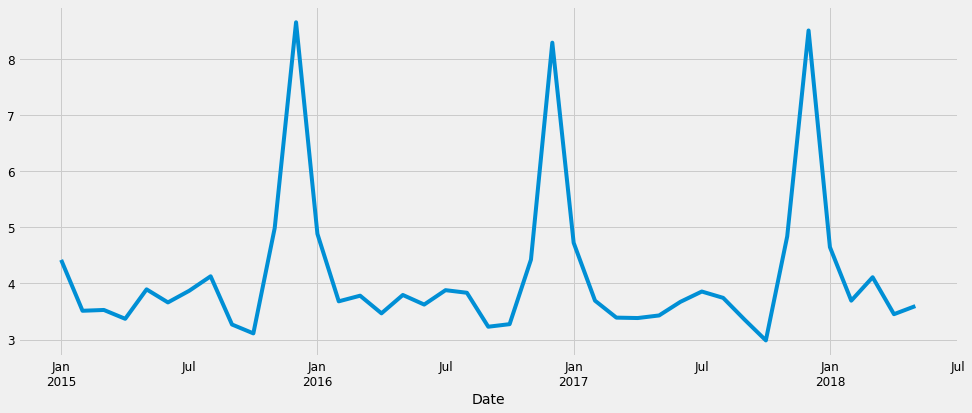

In [53]:
y.plot(figsize=(15, 6))
plt.show()

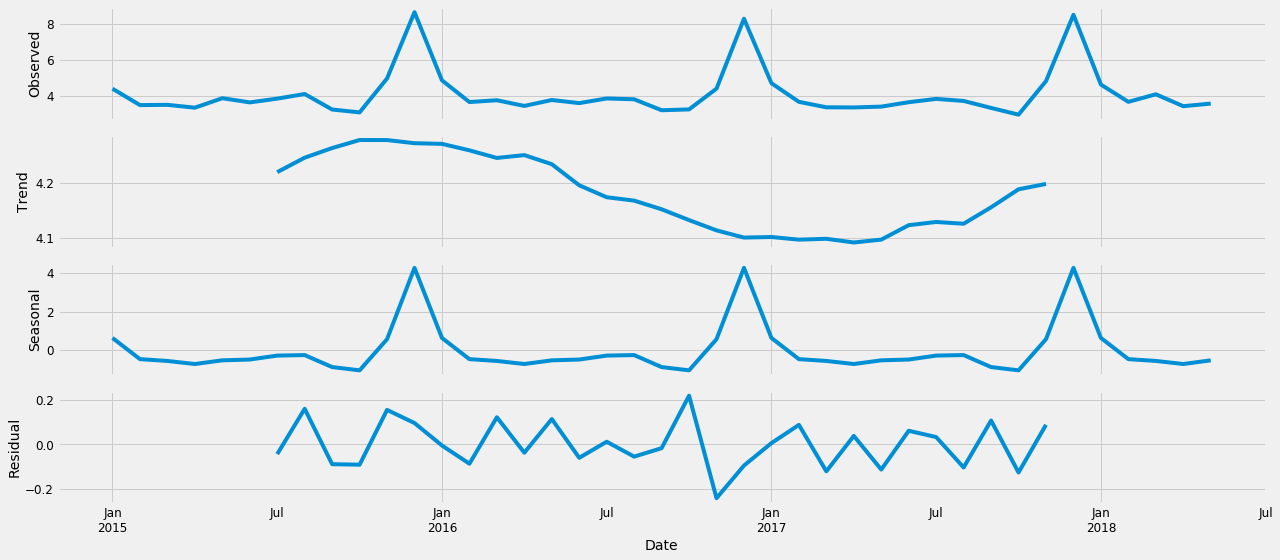

In [54]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Time series forecasting with ARIMA - Traffics

In [55]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [56]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:232.94453259730503
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1452.7981829980818
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5.887029478059545


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10.084571640407692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1.5485443768036031
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-3.1897276309590863
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:193.78750826604474
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1232.388297986613
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:7.977357222310286
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11.546220390340622
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3.616663623008666
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-1.2713526173272696
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:148.80147349396617
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1153.28589361382

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:21.30584787016378
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:23.493598309670016
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1251.859043323103
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:9.304357745972606
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:138.4991771593891


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1037.040429832167
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:10.184026050422387
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:11.380292681309822


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1005.7231565194814
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:2.5865090110001185
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:152.371278253014


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1323.2932020918915
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:7.1527693611002645
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:8.788376118316554
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2.8142722735375827
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-0.5659510972206796
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:143.52144714816671


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1085.7897198177511
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:8.342946186188268
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:9.186108922817338
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:4.084005257344254


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1.4331624301742654
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:150.05742768940107
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1182.5509002443641
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:15.096543315504062
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:16.360537593311797
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1150.0414044826364


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:7.624046835243213
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:136.93893154919755


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1059.5328130673686
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:11.154987043072977
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:10.718043940080427


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1028.1727418260698
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:5.159638697896337


# Fitting the ARIMA model

In [57]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0497      0.799     -0.062      0.950      -1.616       1.517
ar.S.L12      -0.7377      0.201     -3.679      0.000      -1.131      -0.345
sigma2         0.0388      0.013      2.983      0.003       0.013       0.064


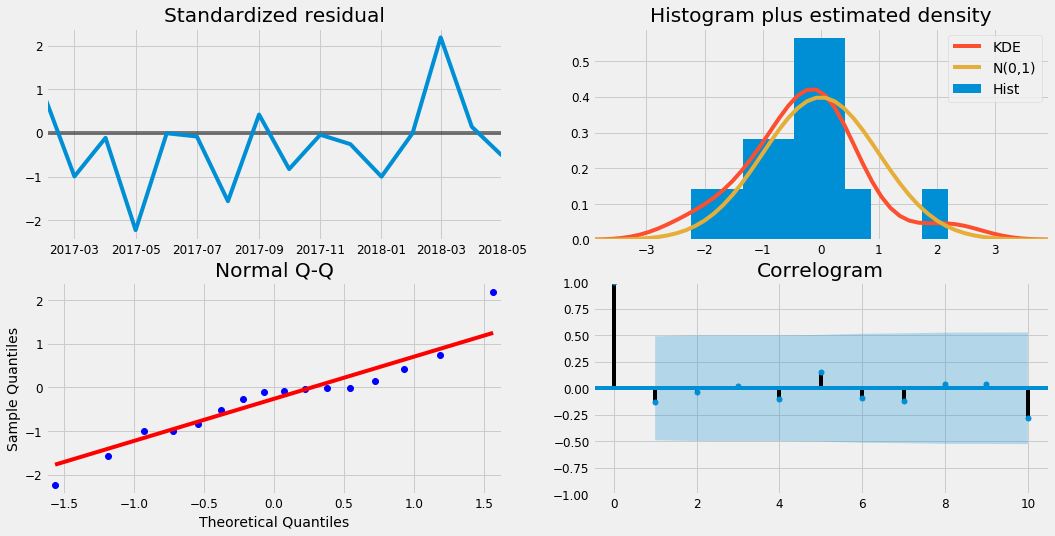

In [58]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating forecasts

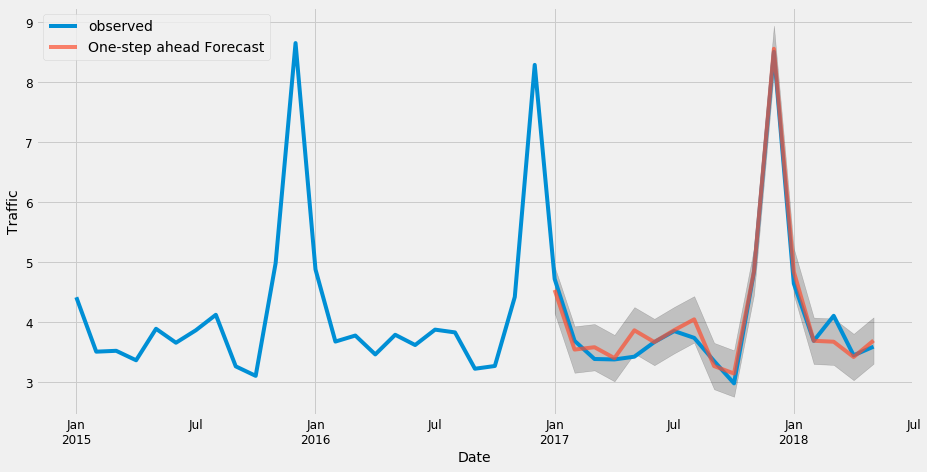

In [59]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic')
plt.legend()
plt.show()

In [60]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.04


In [61]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.2


# Producing and visualizing forecasts

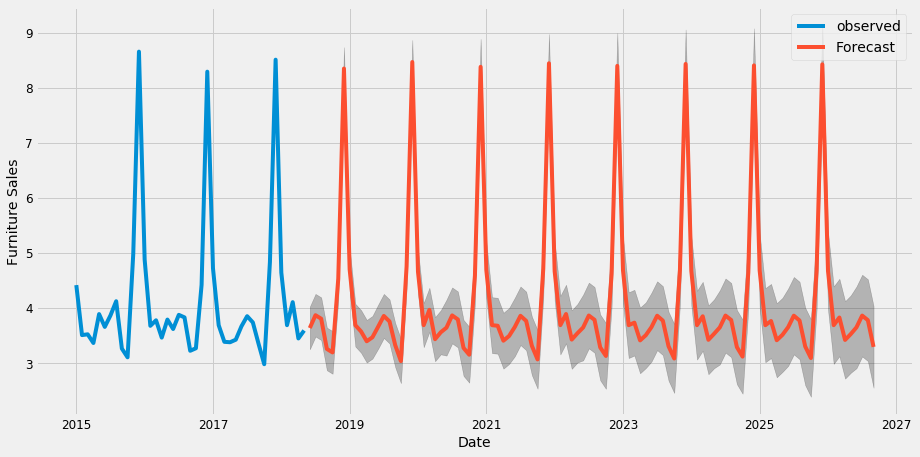

In [62]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Time Series Modeling with Prophet

Forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, I will be using Prophet to get a model up and running.

In [2]:
df1=pd.read_csv("training_Sales.csv")
df2=pd.read_csv("training_Traffic.csv")

In [3]:
df1['Date'] =  pd.to_datetime(df1['Date'], format='%Y%m%d %H:%M:%S.%f')
df2['Date'] =  pd.to_datetime(df2['Date'], format='%Y%m%d %H:%M:%S.%f')

In [4]:
df1 = df1.rename(columns={'Date': 'ds','Value': 'y'})
df1.head()

,ds,y
0,2013-11-07 13:00:00,830
1,2013-11-07 13:15:00,885
2,2013-11-07 13:30:00,938
3,2013-11-07 13:45:00,804
4,2013-11-07 14:00:00,793


In [5]:
df2 = df2.rename(columns={'Date': 'ds','Value': 'y'})
df2.head()

,ds,y
0,2015-01-01 10:00:00,0
1,2015-01-01 10:15:00,1
2,2015-01-01 10:30:00,4
3,2015-01-01 10:45:00,3
4,2015-01-01 11:00:00,1


In [6]:
from fbprophet import Prophet

sales_model = Prophet(interval_width=0.95)
sales_model.fit(df1)

C:\Users\Alireza\Anaconda3\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
C:\Users\Alireza\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


C:\Users\Alireza\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1296x432 with 0 Axes>

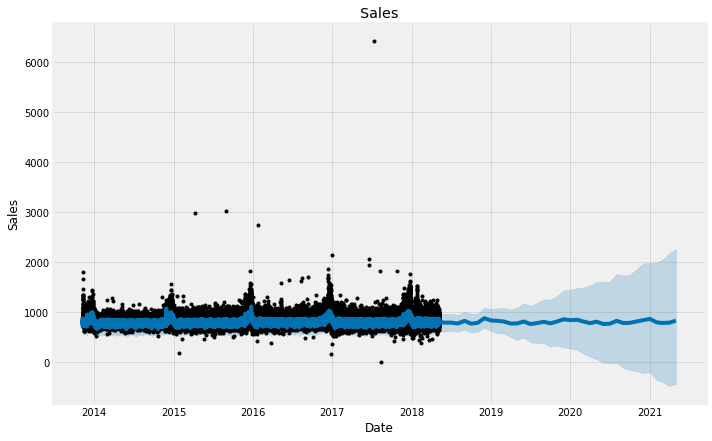

In [7]:
sales_forecast = sales_model.make_future_dataframe(periods=36, freq='MS')
sales_forecast = sales_model.predict(sales_forecast)

plt.figure(figsize=(18, 6))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Sales');

In [8]:
traffic_model = Prophet(interval_width=0.95)
traffic_model.fit(df2)

traffic_forecast = traffic_model.make_future_dataframe(periods=36, freq='MS')
traffic_forecast = traffic_model.predict(traffic_forecast)

Text(0.5, 1.0, 'Traffic')

<Figure size 1296x432 with 0 Axes>

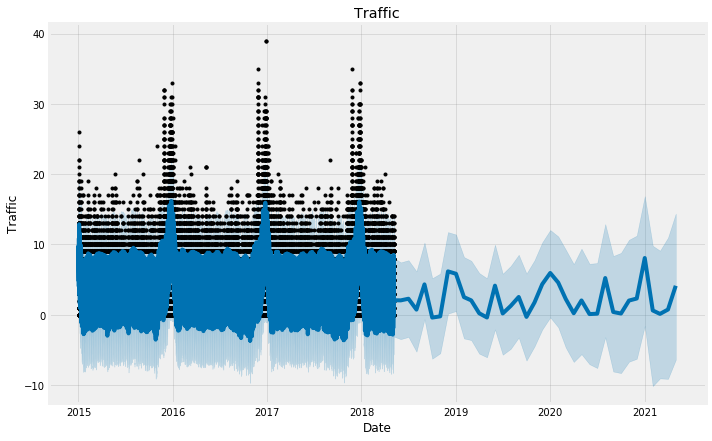

In [9]:
plt.figure(figsize=(18, 6))
traffic_model.plot(traffic_forecast, xlabel = 'Date', ylabel = 'Traffic')
plt.title('Traffic')

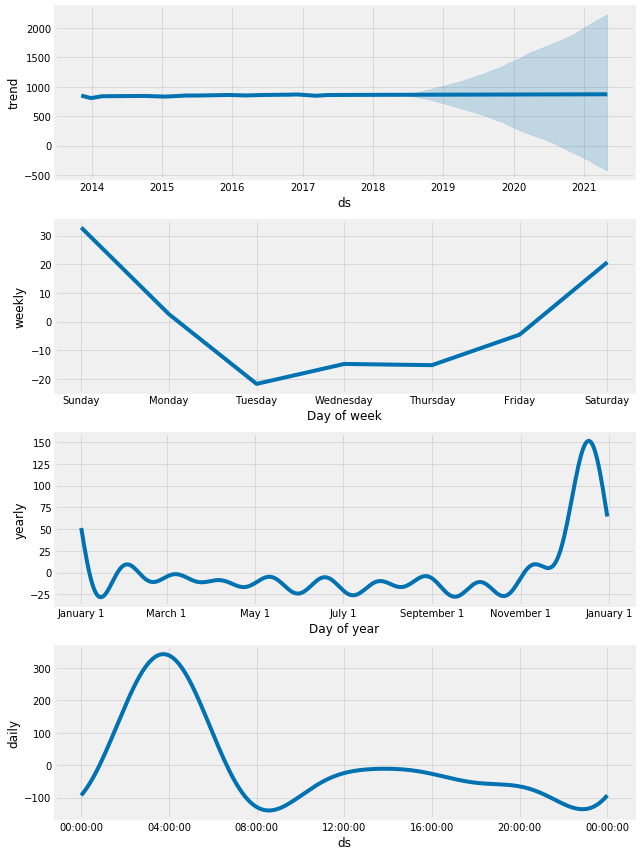

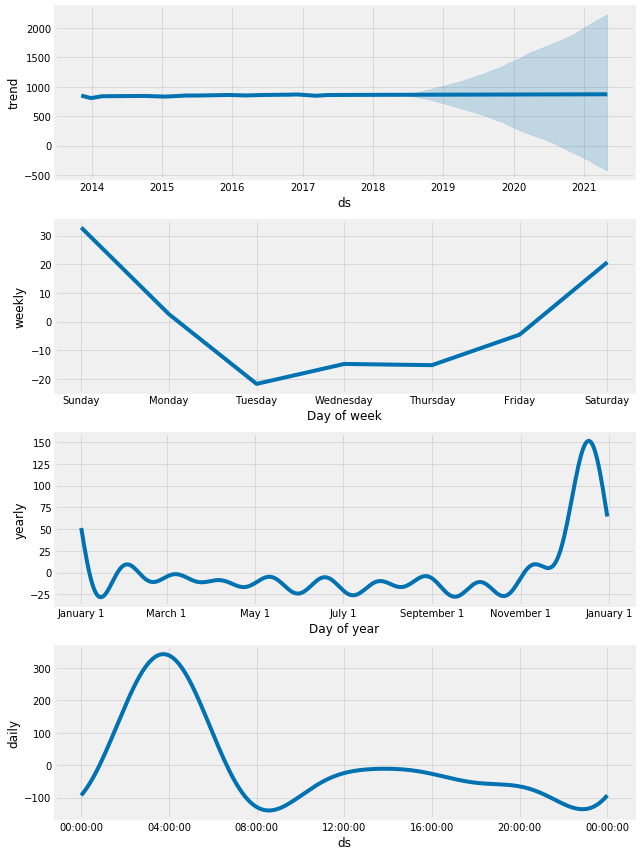

In [10]:
sales_model.plot_components(sales_forecast)

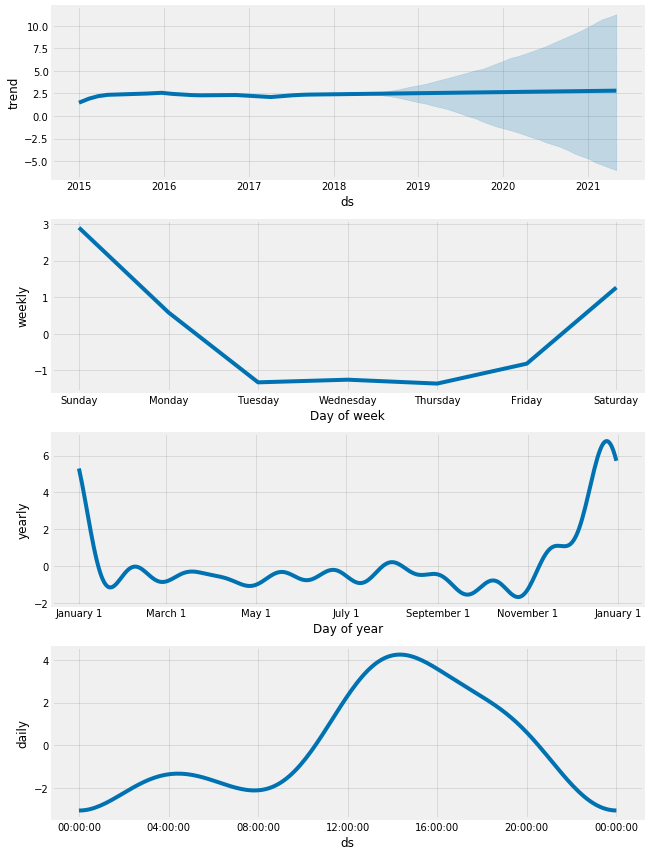

In [11]:
traffic_model.plot_components(traffic_forecast);